Küsimused

### 3.1 Artikli mõtted

* Kasuta BWR benchmarki. Arvuta selle põhjal tuumkütuse koostis (tehtud), ning kasuta seda järgnevates analüüsides.

* Loo väljamõeldud tüüp-väikemoodulreaktor (midagi analoogset BWRX-300'le) 

* Leia kuskilt mingi ILW source term, mis oleks seotav reaktori töötundide/võimsusega.

* Analüüsi SNF jäätmete kogust lähtuvalt burnupist, tsükli pikkusest.

* Arvuta ILW jäätmepakendite distribution in time, kuidas seda visualiseerida?

* Millal võiksime saavutada (SNF, ILW) vabastamistaseme ületamise?

* Esmane transportation, pool release, dry storage and packaging time.

* Propagation of inventory distributions.

### 1.1 Artikli mõtted

* Kas on mõistlikum teha eraldi dry storage või piisab suure pooli ehitamisest (see peaks sõltuma kui suurt pooli on vaja teha, ja mis on total decay heat output (millal saab jäätmed ära pakendada ja teele saata)).

* Kuidas oleks mõistlik dimensioneerida oma jäätmekäitlusvõimekust (dry storage / disposal facilities), kui pretreatment/processing tehakse välismaal. Kuidas siis kui pretreatment/processing kodumaal, aga final disposal välismaal.

* Kasuta simplified cost modeleid, et analüüsida erinevate võimaluste hinda.

* Kas transport caskid saavad temperatuuri-nõuetega hakkama, mis on selle järgi kõige varasem aeg, millal saab fueli üldse shippida?

* Vaata, millised piirangud võivad olla SNF kütuse käitlemisel (Fermi uuringu tulemusi osaliselt publishida?)

* Võrdle kahte route, üks kus viiakse välismaale nii varakult kui võimalik (piiratud by cask transport heat limit ja dose rate 10 mSv/hr) ja saab uurida, kui suures mahus peaks riigis ehitama intermediate storage capability.

* Millised peaksid olema optimaalsed conditioning facility jne võimekus/suurus, et jäätmed saaksid käideldud jooksvalt/kõik korraga 5/10 nt aasta jooksul.

* Millal võiksime saavutada vabastamistaseme ületamise?

7 pages of content:

* 1 page is introduction,

* 2 pages is methodology, (Model description)

* 1 Page is OpenMC benchmarking.

* 1 Page is benchmarking the software against the OpenMC script.

* 2 Pages is advancing the model and showing the features of the software.

Transport canisters:

CASTOR V/52 BWR 52 assemblies 40 kW

HI-STAR 80  BWR 32 assemblies 54 kW

In [4]:
# ┌───────────┐  Used  ┌───────────┐      ┌───────────┐
# │  Reactor  │  Fuel  │ On-Site   ├──────► Off-Site  │
# │  Node     ├────────► Fuel Pool │      │ Dry Stor. │
# └─────┬─────┘        └───────────┘      └─────┬─────┘
#       │ Liquid                                │      
#       │ Waste                                 │      
# ┌─────▼──────┐       ┌────────────┐     ┌─────▼─────┐
# │ Liq. Waste │       │ Geological │     │ Packaging │
# │ Stor. Tank │       │ Disposal   ◄─────┤ Facility  │
# └─────┬──────┘       └────────────┘     └───────────┘
#       │                                   
#       │                                              
# ┌─────▼──────┐       ┌───────────┐     ┌────────────┐
# │ Condition. ├───────► Interim   │     │ Near-Surf. │
# │ Facility   │       │ Storage   ├─────► Disposal   │
# └────────────┘       └───────────┘     └────────────┘

# Wastimate SNF and LLW benchmark

In [1]:
from Wastimate import *
import json
import scipy.stats as sc

## 1. Spent Fuel Management

In [2]:
### Define Spent Fuel Inventory ###
###################################
with open("STEP3_Fuel_Burnup_50.json", "r") as json_file: # Generate new file according to the benchmark.
    TempInv = json.load(json_file)

Spent_Fuel_Inventory = {}
for nuc, value in TempInv.items():
    if value > 1e18:
        Spent_Fuel_Inventory[nuc] = value

#for nuc, value in Spent_Fuel_Inventory.items():
#    error = 0.3 # 10%
#    Spent_Fuel_Inventory[nuc] = sc.norm(loc=value, scale=value*error)

batches = 100

spent_assembly = Package(mass=1, inventory=Spent_Fuel_Inventory, batches=batches, decay_chain=True)

In [3]:
### UO2 Fuel Connections ###
############################
# Define burnup and calculate the amount of fuel generated each year. Use a refueling cycle of 12 months.
Burnup           = 50 # MWd/kg
ReactorLifetime  = 60 # years
CapacityFactor   = 0.90 # US level # https://www.iges.or.jp/en/publication_documents/pub/issue/en/12008/20220406+IGES+Nuclear+Report.pdf
ReactorPower     = 900 # MW # 
ReactorElectric  = 300  # MW # Small-scale reactors max limit, which is suitable for regular countries.
FuelMass         = 170.9 #kgU # Options of Principles of Fuel Debris Criticality Control in Fukushima Daiichi Reactors
CycleLength      = 1 # one to two years.

OperationTime       = ReactorLifetime * 365 * CapacityFactor # days
TotalEnergyProduced = ReactorPower * OperationTime # MW * days
SpentFuelProduced   = TotalEnergyProduced / Burnup # kg
AssembliesProduced  = int(np.ceil(SpentFuelProduced / FuelMass))
SingleSwap          = int(AssembliesProduced / (ReactorLifetime / CycleLength))

PoolCapacity   = 8 * SingleSwap # assemblies 
CoreAssemblies = 240

In [4]:
### Dry storage requirements ###
################################
TotalCaskLimit    = 50000 - 10000 # 5000 W and 1000 W safety buffer
TotalCaskCapacity = 89 # spent fuel assemblies

DryAssemblyLimit = TotalCaskLimit / TotalCaskCapacity

### Packaging facility capacity ###
###################################
CanisterCapacity = 12
CanistersOut = 3 # 4000 packages over 30 years, is it sensible for this rate for smaller plants? Optimization question. https://curie.pnnl.gov/system/files/SKB_TR-01-03.pdf # You should research/optimize this value! Currently, I dont have a good guess for this value.
PackagingHeatLimit = 1500 # 1.5 kW per canister

### Geological disposal capacity ###
####################################
GeologicalRate = 100 # https://curie.pnnl.gov/system/files/SKB_TR-01-03.pdf # Should probably be optimized for smaller plants?

In [5]:
### Simulation SNF Setup ###
############################
OS_Pool            = Node()
OF_Dry             = Node()
Packaging          = Node()

Reactor = Source(awaynode=OS_Pool, package=spent_assembly, magnitude=SingleSwap) #SingleSwap

PoolDry_Mass_Criteria = {"region":"node", "variable":"mass", "principle":"max", "criteria":PoolCapacity}
PoolDry_Heat_Criteria = {"region":"package", "variable":"heat", "principle":"min", "criteria":DryAssemblyLimit}

Link_Pool_Dry     = Order(homenode=OF_Dry, ordernodes=[OS_Pool], magnitude=TotalCaskCapacity,
                          criteria=[PoolDry_Heat_Criteria])

Packaging_Instruct = {"package_out":1} # CanisterCapacity homogenized into 1 package
Packaging_Criteria = {"region":"package", "variable":"heat", "principle":"min", "criteria":PackagingHeatLimit} # 1.5 kW limit per package

Links_Dry_Pack = []
for i in range(CanistersOut):
    Links_Dry_Pack.append(Order(homenode=Packaging, ordernodes=[OF_Dry], magnitude=CanisterCapacity,
                          crumbs=False, mode="Combine", instruct=Packaging_Instruct, criteria=[Packaging_Criteria]))

In [6]:
timestep_unit = 1*60*60*24*365
SNF_verse = (Universe(stepsize=timestep_unit)
             + OS_Pool + OF_Dry + Packaging
             + Reactor + Link_Pool_Dry) #+ Link_Pack_Geo)

for link in Links_Dry_Pack:
    SNF_verse += link

In [7]:
### Run the simulation ###
##########################
SNF_verse.simulate(timesteps=60)

SNF_verse -= Reactor

SNF_verse -= Link_Pool_Dry
Link_Pool_Dry = Order(homenode=OF_Dry, ordernodes=[OS_Pool], magnitude=TotalCaskCapacity,
                      criteria=[PoolDry_Heat_Criteria], crumbs=True)
SNF_verse += Link_Pool_Dry

SNF_verse.simulate(timesteps=140)

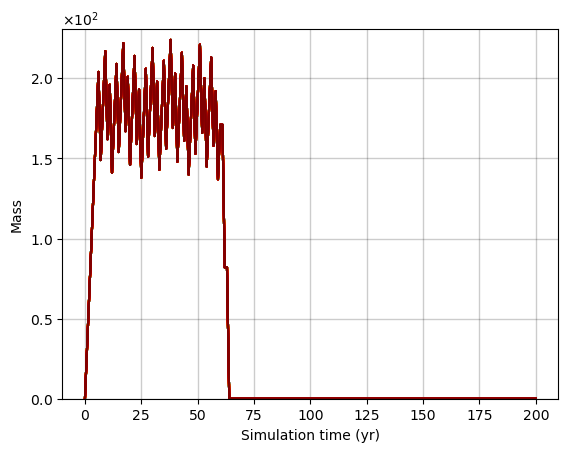

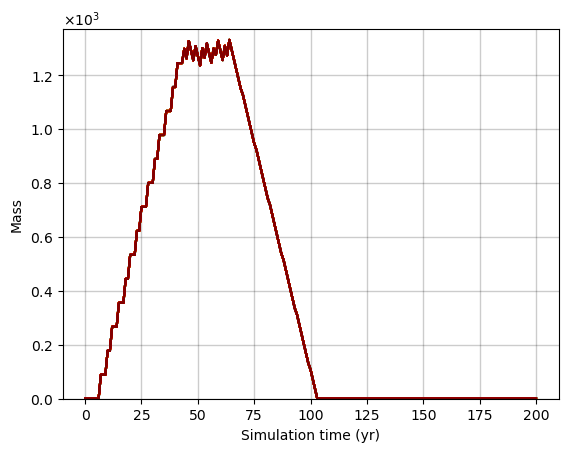

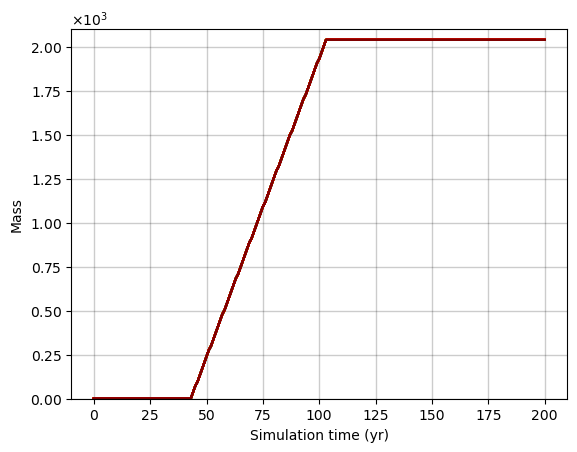

In [8]:
### Visualize the SNF results ###
#################################
plot_type = "line"
pool_mass = SNF_verse.plot(OS_Pool, variable="mass", time_units="yr", plottype=plot_type);
dry_mass = SNF_verse.plot(OF_Dry, variable="mass", time_units="yr", plottype=plot_type);
packaging_mass = SNF_verse.plot(Packaging, variable="mass", time_units="yr", plottype=plot_type);

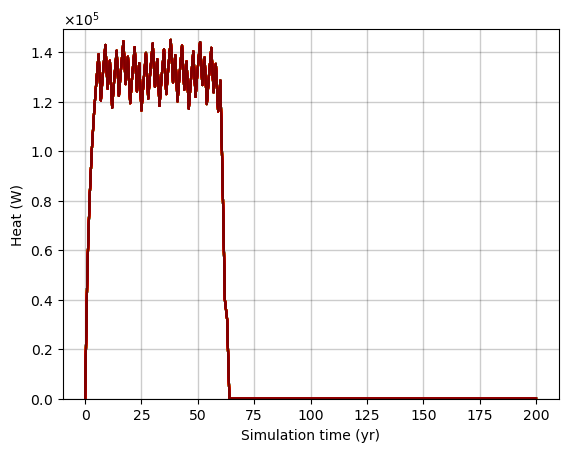

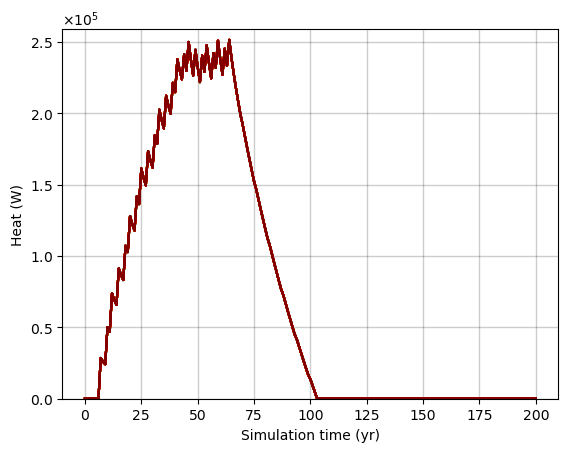

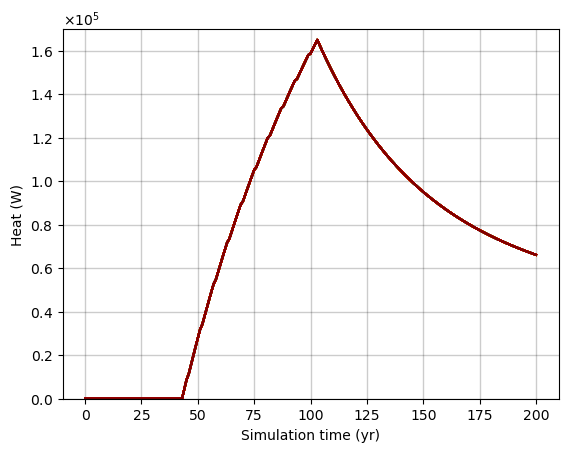

In [9]:
plot_type = "line"
pool_heat = SNF_verse.plot(OS_Pool, variable="heat", time_units="yr", plottype=plot_type);
dry_heat = SNF_verse.plot(OF_Dry, variable="heat", time_units="yr", plottype=plot_type);
packaging_heat = SNF_verse.plot(Packaging, variable="heat", time_units="yr", plottype=plot_type);
#SNF_verse.plot(Geological_Storage, variable="heat", time_units="yr", plottype=plot_type);

In [14]:
#SNF_verse.plot(OS_Pool, variable="heat", time_units="yr", plottype="mesh-hist", filename="spool-hist_err.png");
#SNF_verse.plot(OF_Dry, variable="heat", time_units="yr", plottype="mesh-hist", filename="sdry-hist_err.png");
#SNF_verse.plot(Packaging, variable="heat", time_units="yr", plottype="mesh-hist", filename="spackage-hist_err.png");

## 2. Resin Management

In [10]:
### ILW waste source characerization ###
########################################
batches = 100

LiquidsPerEnergyYear = 0.223 #m3/MW(e)yr # Data Base for Radioactive Waste Management, 1981 NRC
LiquidsProduced = int(np.ceil(ReactorElectric * CapacityFactor * LiquidsPerEnergyYear * CycleLength)) 

### NEED GOOD VALUES FOR THESE or SENSITIVITY ANALYSIS ###
TankConditioningCapacity = 45 # I THINK IT IS IMPORTANT TO OPTIMIZE THIS VALUE. https://www-pub.iaea.org/MTCD/Publications/PDF/TE-1701_web.pdf
WasteDemandPerPackage = 0.22/1.4*8 # Data Base for Radioactive Waste Management, 1981 NRC and COST/BENEFIT SYSTEMS ANALYSIS AND COMPARISON OF SHALLOW LAND BURIAL AND GREATER CONFINEMENT DISPOSAL FOR THE FINAL DISPOSITION OF LOW-LEVEL RADIOACTIVE WASTES

# Isotopic concentration Ci per m3
LiquidActivities = {"H3":6.24E-04, "C14":3.89E-05, "Fe55":7.60E-02, "Ni59":7.85E-05, "Co60":1.27E-01, "Ni63":1.72E-03,
                   "Nb94":2.48E-06, "Sr90":1.18E-04, "Tc99":2.50E-06, "I129": 6.65E-06, "Cs135":2.50E-06, "Cs137":6.65E-02}

print(LiquidsProduced)

# From Curies/m3 to Bq
for nuc, value in LiquidActivities.items():
    act_value = LiquidsProduced * value * 3.7 * 10**10
    LiquidActivities[nuc] = sc.norm(loc=act_value, scale=act_value*0.1)

61


In [11]:
### Simulation ILW Setup ###
############################

# Add proper inventory definition
liquid_waste = Package(mass=LiquidsProduced, inventory=LiquidActivities, mode="activity", batches=batches)
liquid_waste.Calculate_Bateman()

InputInventory = copy.deepcopy(liquid_waste.Inventory)
InputHalflives = copy.deepcopy(liquid_waste.HalfLifeDict)
InputBateman   = copy.deepcopy(liquid_waste.BatemanMatrix)

Liquids_Tank = Node()
Liquids_Conditioning = Node()
Liquids_Release = Node()

# Add proper amount according to the 1982 report.
Exchanger = Source(awaynode=Liquids_Tank, package=liquid_waste, magnitude=1)

Tank_Instruct = {"package_out":TankConditioningCapacity, "package_mass":WasteDemandPerPackage}

Criteria_Nuclides = [["Cs137", "Ba137_m1"], "Co60", ["Sr90", "Y90"], "Fe55"]
Criteria_Values = np.array([6e-1, 4e-1, 3e-1, 4e1])*1e12*1 # TBq and 8 barrels.
Conditioning_Criteria = {"region":"package", "variable":"activity", "principle":"min",
                         "nuclide":Criteria_Nuclides, "criteria":Criteria_Values}

Link_Tank_Cond = Order(homenode=Liquids_Conditioning, ordernodes=[Liquids_Tank], instruct=Tank_Instruct,
                       magnitude=0, mode="Separate", crumbs=False, criteria=[Conditioning_Criteria])

Release_Nuclides = ["Cs137", "Co60", "Sr90", "Fe55"]
Release_Values = np.array([1e4, 1e5, 1e4, 1e6]) # https://www.riigiteataja.ee/aktilisa/1270/8202/1006/KKM_m40_lisa3.pdf#
Release_Criteria = {"region":"package", "variable":"activity", "principle":"min",
                         "nuclide":Release_Nuclides, "criteria":Release_Values}

#Link_Cond_Release = Order(homenode=Liquids_Release, ordernodes=[Liquids_Conditioning],
#                       magnitude=10000, crumbs=True, criteria=[Release_Criteria])

In [12]:
ILW_verse = (Universe(stepsize=timestep_unit)
             + Liquids_Tank + Liquids_Conditioning + Liquids_Release
             + Exchanger + Link_Tank_Cond)

for i in range(50):
    ILW_verse += Order(homenode=Liquids_Release, ordernodes=[Liquids_Conditioning],
                           magnitude=1, crumbs=True, criteria=[Release_Criteria])

In [13]:
### Run the simulation ###
##########################
ILW_verse.simulate(timesteps=60, num_of_cores=1)

ILW_verse -= Exchanger

ILW_verse.simulate(timesteps=140, num_of_cores=1)

# For release levels
#ILW_verse.simulate(timesteps=500)

### Plot Settings ###
#####################
plot_type = "line"

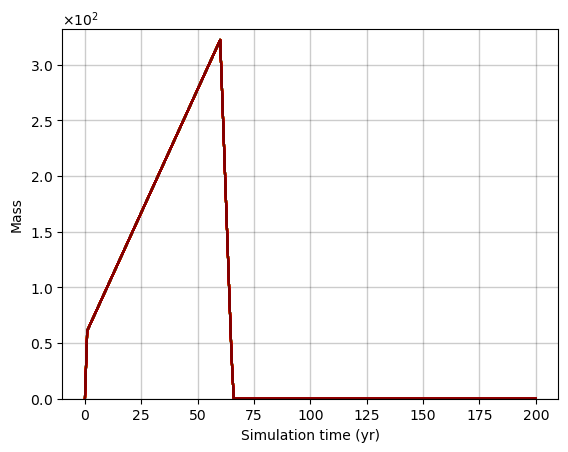

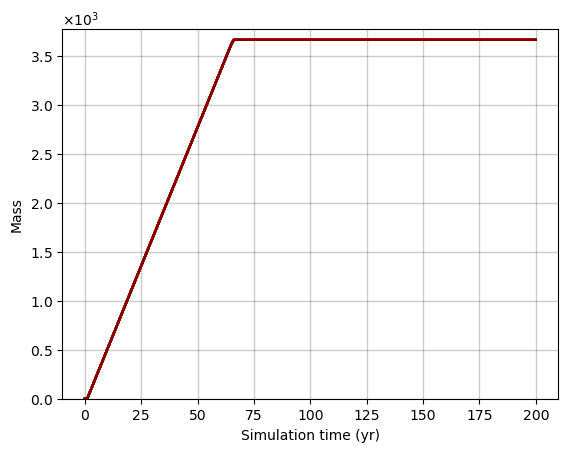

C:\Users\hando\Documents\Paper 3.5\New_Wastimate_Order_Multi_v3.py:1691: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(np.min(data)*0.99, np.max(data)*1.03)


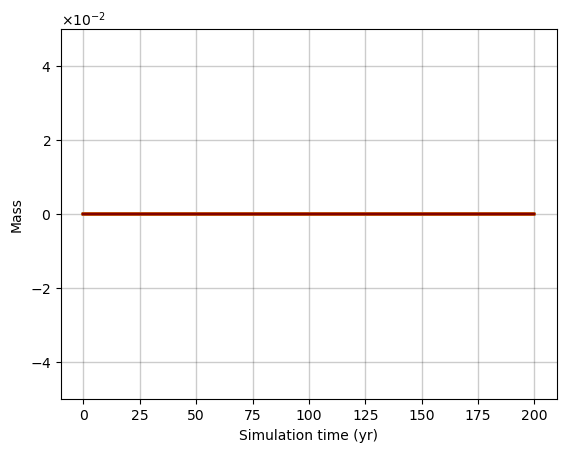

In [14]:
### Visualize the ILW results ###
#################################
liquids_mass = ILW_verse.plot(Liquids_Tank, variable="mass", time_units="yr", plottype=plot_type);
conditioning_mass = ILW_verse.plot(Liquids_Conditioning, variable="mass", time_units="yr", plottype=plot_type);
release_mass = ILW_verse.plot(Liquids_Release, variable="mass", time_units="yr", plottype=plot_type);

In [ ]:
plot_type = "mesh"
liquids_activity = ILW_verse.plot(Liquids_Conditioning, variable="activity", time_units="yr", plottype="mesh-hist", filename="cond_dist");
#conditioning_activity = ILW_verse.plot(Liquids_Conditioning, variable="activity", time_units="yr", plottype=plot_type, filename="Pconditioning_activity");
#release_activity = ILW_verse.plot(Liquids_Release, variable="activity", time_units="yr", plottype=plot_type);

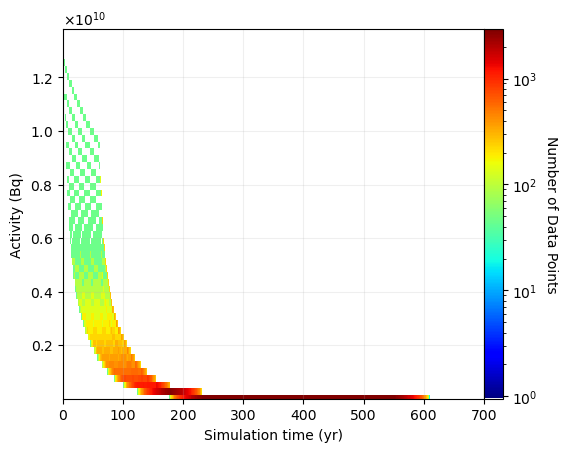

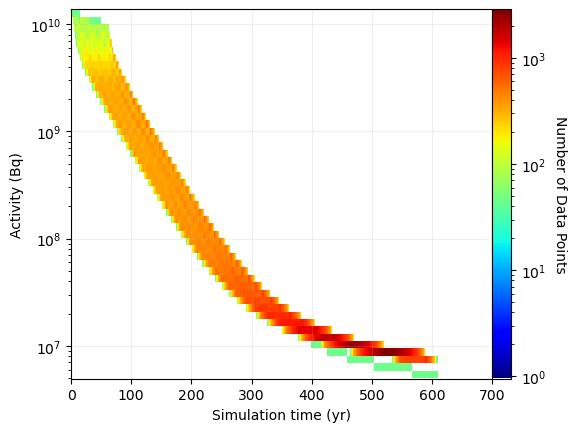

In [105]:
ILW_verse.plot(Liquids_Conditioning, variable="activity", time_units="yr", plottype="mesh-hist", scale=("lin", "lin"));
ILW_verse.plot(Liquids_Conditioning, variable="activity", time_units="yr", plottype="mesh-hist", scale=("lin", "log"));

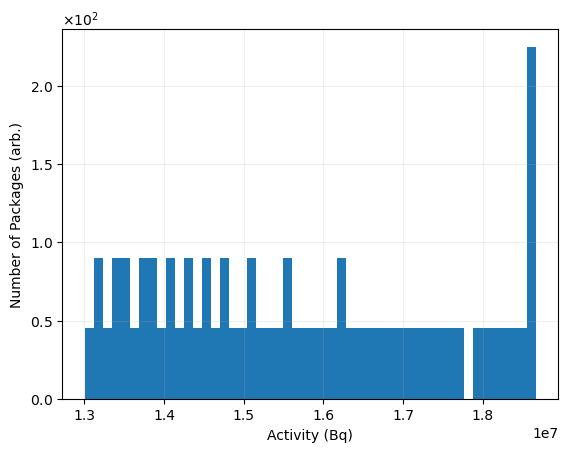

In [116]:
ILW_verse.plot(Liquids_Conditioning, variable="activity", time_units="yr", plottype="hist", time=376);


## 3. Modeling the SNF problem manually

In [86]:
# Check at what time does the packages satisfy dry storage heat requirements.
dry_achieved = False

for time in spent_assembly.HeatStates.keys():
    PackageHeat = spent_assembly.HeatStates[time].sum(axis=0)
    if PackageHeat < DryAssemblyLimit and not dry_achieved:
        print(f"Dry Storage achieved in {time/timestep_unit} years,\nHeat output of {PackageHeat[0]} W,\nLimit of {DryAssemblyLimit} W")
        dry_achieved = True

    if PackageHeat < PackagingHeatLimit / 12:
        print(f"Packaging achieved in {time/timestep_unit} years,\nHeat output of {PackageHeat[0]} W,\nLimit of {PackagingHeatLimit/12} W")
        break

Dry Storage achieved in 4.0 years,
Heat output of 442.68274621793563 W,
Limit of 449.438202247191 W
Packaging achieved in 43.0 years,
Heat output of 124.01023318063483 W,
Limit of 125.0 W


Dry Storage achieved in 1436.0 days,<br>
Heat output of 449.42829802057497 W,<br>
Limit of 449.438202247191 W<br>
Packaging achieved in 15527.0 days,<br>
Heat output of 124.99794625885843 W,<br>
Limit of 125.0 W


Dry Storage achieved in 4.0 years,<br>
Heat output of 442.6827462178801 W,<br>
Limit of 449.438202247191 W<br>
Packaging achieved in 43.0 years,<br>
Heat output of 124.01023318059089 W,<br>
Limit of 125.0 W

In [87]:
#print(spent_assembly.InventoryStates[0])
#print(spent_assembly.ActivityStates[0])
#print(spent_assembly.HeatStates[0])
#print(spent_assembly.NuclideDict)

In [88]:
simulation_time = 200
reactor_life = 60

In [89]:
def check_pool_criteria(list_of_packages):
    for package in list_of_packages:
        if package < timestep_unit * 4:
            return False
    return True

def check_dry_criteria(list_of_packages):
    for package in list_of_packages:
        if package < timestep_unit * 43:
            return False
    return True

# Record keeping lists.
TotalPoolPackageList = [[]]
TotalDryPackageList = [[]]
TotalPackagingPackageList = [[]]

# List of packages in Pool storage
PoolPackageList = []
DryPackageList = []
PackagingPackageList = []
for i in range(simulation_time):    
    # Move packages from Pool to Dry
    if len(PoolPackageList) >= TotalCaskCapacity:
        if check_pool_criteria(PoolPackageList[:TotalCaskCapacity]):
            DryPackageList += PoolPackageList[:TotalCaskCapacity]
            del PoolPackageList[:TotalCaskCapacity]

    elif len(PoolPackageList) < TotalCaskCapacity and i >= 60:
        if check_pool_criteria(PoolPackageList[:]):
            DryPackageList += PoolPackageList[:]
            del PoolPackageList[:]
            
    # Move packages from Dry to Packaging
    for k in range(CanistersOut):
        if len(DryPackageList) >= CanisterCapacity:
            if check_dry_criteria(DryPackageList[:CanisterCapacity]):
                PackagingPackageList += DryPackageList[:CanisterCapacity]
                del DryPackageList[:CanisterCapacity]

    # Add packages
    if i < reactor_life:
        PoolPackageList += [0]*SingleSwap
        
    # Age packages
    for idx, package in enumerate(PoolPackageList):
        PoolPackageList[idx] = package + timestep_unit
    for idx, package in enumerate(DryPackageList):
        DryPackageList[idx] = package + timestep_unit
    for idx, package in enumerate(PackagingPackageList):
        PackagingPackageList[idx] = package + timestep_unit
        
    # Record state
    TotalPoolPackageList.append(PoolPackageList.copy())
    TotalDryPackageList.append(DryPackageList.copy())
    TotalPackagingPackageList.append(PackagingPackageList.copy())

In [90]:
# Convert Total Histories into observable quantities.
X = list(range(0, simulation_time+1))

PoolMassList = []
for PPL in TotalPoolPackageList:
    PoolMassList.append(len(PPL))

PoolHeatList = []
for StatePackages in TotalPoolPackageList:
    stateheat = 0
    for package in StatePackages:
        stateheat += spent_assembly.HeatStates[package].sum(axis=0)
    PoolHeatList.append(stateheat)

DryMassList = []
for DPL in TotalDryPackageList:
    DryMassList.append(len(DPL))
    
DryHeatList = []
for StatePackages in TotalDryPackageList:
    stateheat = 0
    for package in StatePackages:
        stateheat += spent_assembly.HeatStates[package].sum(axis=0)
    DryHeatList.append(stateheat)

    
PackagingMassList = []
for PPL in TotalPackagingPackageList:
    PackagingMassList.append(len(PPL))
    
PackagingHeatList = []
for StatePackages in TotalPackagingPackageList:
    stateheat = 0
    for package in StatePackages:
        stateheat += spent_assembly.HeatStates[package].sum(axis=0)
    PackagingHeatList.append(stateheat)

C:\Users\hando\AppData\Local\Temp\ipykernel_11840\1390017616.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  line21, = plot2.plot(X, np.array(PoolHeatList)/1000, color="red", linestyle="-", label='Wet Storage - Wastimate', alpha=1, linewidth=2)
C:\Users\hando\AppData\Local\Temp\ipykernel_11840\1390017616.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  line23, = plot2.plot(X, np.array(DryHeatList)/1000, color="c", linestyle="-", label='Dry Storage - Wastimate', linewidth=2, alpha=1)
C:\Users\hando\AppData\Local\Temp\ipykernel_11840\139001761

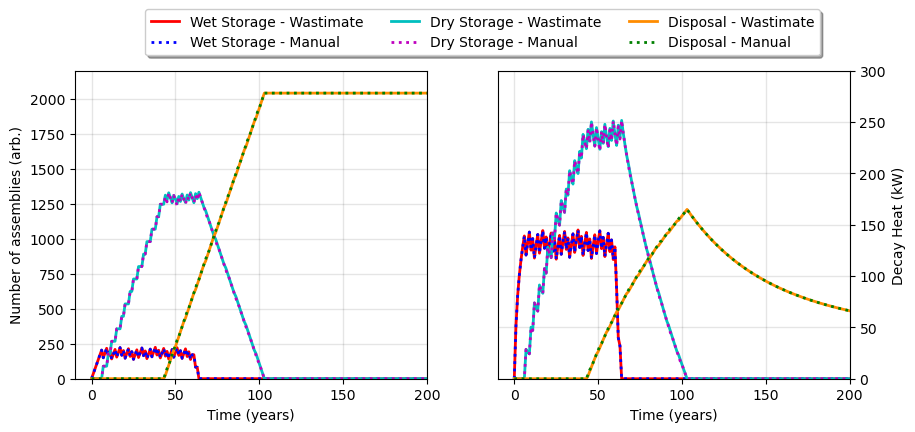

In [100]:
import matplotlib.pyplot as plt

X = list(range(0, 200+1))

# Sample data
fig = plt.gcf()

# Create figure and axis objects
# Placing the plots in the plane 
plot1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1) 
plot2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1) 
#plot4 = plt.subplot2grid((3, 3), (1, 0), rowspan=2) 

# Plot y1 on the primary y-axis
line11, = plot1.plot(X, PoolMassList, color="red", linestyle="-", label='Wet Storage - Wastimate', alpha=1, linewidth=2)
line12, = plot1.plot(X, pool_mass, color="blue", linestyle=":", label='Wet Storage - Manual', alpha=1, linewidth=2)
line13, = plot1.plot(X, DryMassList, color="c", linestyle="-", label='Dry Storage - Wastimate', linewidth=2, alpha=1)
line14, = plot1.plot(X, dry_mass, color="m", linestyle=":", label='Dry Storage - Manual', alpha=1, linewidth=2)
line15, = plot1.plot(X, PackagingMassList, color="darkorange", linestyle="-", label='Disposal - Wastimate', linewidth=2, alpha=1)
line16, = plot1.plot(X, packaging_mass, color="green", linestyle=":", label='Disposal - Manual', alpha=1, linewidth=2)

plot1.set_xlabel('Time (years)')
plot1.set_ylabel('Number of assemblies (arb.)', color='k')
plot1.tick_params(axis='y', colors='k')
plot1.set_xlim([-10,200])
plot1.set_ylim([-0.5, 2200])
#plot1.set_yscale("symlog")

#plot2 = plot1.twinx()
#line21, = plot2.plot(X, LiquidsActivityList, color="green", linestyle="-", label='Activity - Wastimate', alpha=1)
#line22, = plot2.plot(X, liquids_activity, color="violet", linestyle="--", label='Activity - Manual', alpha=1, linewidth=2, dashes=(5, 5))
#plot2.set_ylabel('Y2', color='b')
#plot2.tick_params(axis='y', colors='b')

line21, = plot2.plot(X, np.array(PoolHeatList)/1000, color="red", linestyle="-", label='Wet Storage - Wastimate', alpha=1, linewidth=2)
line22, = plot2.plot(X, pool_heat/1000, color="blue", linestyle=":", label='Wet Storage - Manual', alpha=1, linewidth=2)
line23, = plot2.plot(X, np.array(DryHeatList)/1000, color="c", linestyle="-", label='Dry Storage - Wastimate', linewidth=2, alpha=1)
line24, = plot2.plot(X, dry_heat/1000, color="m", linestyle=":", label='Dry Storage - Manual', alpha=1, linewidth=2)
line25, = plot2.plot(X, np.array(PackagingHeatList)/1000, color="darkorange", linestyle="-", label='Disposal - Wastimate', linewidth=2, alpha=1)
line26, = plot2.plot(X, packaging_heat/1000, color="green", linestyle=":", label='Disposal - Manual', alpha=1, linewidth=2)

plot2.set_xlabel('Time (years)')
plot2.set_ylabel('Decay Heat (kW)', color='k')
plot2.tick_params(axis='y', colors='k')
plot2.set_xlim([-10,200])
plot2.set_ylim([0, 3e2])
#plot2.set_yscale("symlog")

# Show legend
lines = [line11, line12, line21, line22]
labels = [line.get_label() for line in lines]
#plt.legend(lines, labels, loc='upper right')

# Show plot
plot1.grid(True, linestyle='-', linewidth=1, color='k', alpha=0.1)
plot2.grid(True, linestyle='-', linewidth=1, color='k', alpha=0.1)

plot2.yaxis.set_label_position("right")
plot2.yaxis.tick_right()

fig.set_size_inches(10, 4)

plt.legend(ncol=3, loc=(-1,1.05), shadow=True)

plt.savefig("SNF benchmark.png", dpi=200, bbox_inches='tight')

plt.show()

## 4. Modeling the LLW problem manually

In [92]:
simulation_time = 700
reactor_life = 60

def inventory_to_activity(inventory_dict, halflife_dict):
    activity_dict = {}
    for key, val in inventory_dict.items():
        activity_dict[key] = val * np.log(2)/halflife_dict[key]
    return activity_dict

#InputActivity = inventory_to_activity(InputInventory, InputHalflives)

# Package Structure -> [mass, nuclide_dict, age]

In [93]:
def check_release_criteria(package):
    if len(package) != 0:
        TempAct = inventory_to_activity(package[1], InputHalflives)
        for nuc, crit in zip(Release_Nuclides, Release_Values):
            if TempAct[nuc] > crit*TankConditioningCapacity:
                return False
    return True

def get_mass(list_of_packages):
    mass = 0
    for package in list_of_packages:
        mass += package[0]
        
    return mass

# Record keeping lists.
TotalLiquidsPackageList = [[0, {}, 0]]
TotalConditioningPackageList = [[]]
TotalReleasePackageList = [[]]

# List of packages in Pool storage
LiquidsState = [0, {}, 0]
ConditioningPackageList = []
ReleasePackageList = []
for i in range(simulation_time):

    # Move packages from Liquids to Conditioning
    if LiquidsState[0] >= TankConditioningCapacity*WasteDemandPerPackage:
        
        # Calculate removed mass
        RemovedMass = TankConditioningCapacity*WasteDemandPerPackage
        Mass_Fraction = RemovedMass / LiquidsState[0]
        
        # Calculate removed inventory
        RemovedInventory = copy.deepcopy(LiquidsState[1])
        for key, value in RemovedInventory.items():
            # Calculate the new liquid tank inventory.
            LiquidsState[1][key] = LiquidsState[1][key] - value*Mass_Fraction
            # Calculate new package inventory.
            RemovedInventory[key] = value*Mass_Fraction
        
        # Move mass and inventory
        LiquidsState[0] -= RemovedMass
        ConditioningPackageList.append([TankConditioningCapacity*WasteDemandPerPackage, RemovedInventory, 0])

    elif LiquidsState[0] > 0 and LiquidsState[0] < TankConditioningCapacity*WasteDemandPerPackage and i >= reactor_life:
        Mass_Fraction = 1
        
        RemovedInventory = copy.deepcopy(LiquidsState[1])
        for key, value in RemovedInventory.items():
            # Calculate the new liquid tank inventory.
            LiquidsState[1][key] = LiquidsState[1][key] - value*Mass_Fraction
            # Calculate new package inventory.
            RemovedInventory[key] = value*Mass_Fraction

        ConditioningPackageList.append([LiquidsState[0], RemovedInventory, 0])
        LiquidsState[0] -= LiquidsState[0]
        
    # Move packages from Conditioning to Release.
    if len(ConditioningPackageList) != 0:
        for package in ConditioningPackageList:
            if check_release_criteria(package):
                ConditioningPackageList.remove(package)
                ReleasePackageList.append(package)

    # Add packages
    if i < reactor_life:
        LiquidsState[0] += LiquidsProduced
        for nuc in InputInventory.keys():
            if nuc in LiquidsState[1]:
                LiquidsState[1][nuc] += InputInventory[nuc]
            else:
                LiquidsState[1][nuc] = InputInventory[nuc]
                
    # Decay the Package
    # Decay the liquid tank inventory.
    inventory_array = np.array(list(LiquidsState[1].values()))
    N_t = CRAM16(InputBateman, inventory_array, 1*60*60*24*365, True)

    for idx, key in enumerate(LiquidsState[1].keys()):
        LiquidsState[1][key] = N_t[idx]
        
    for idx, state in enumerate(ConditioningPackageList):
        if len(state) != 0:
            inventory_array = np.array(list(state[1].values()))
            N_t = CRAM16(InputBateman, inventory_array, 1*60*60*24*365, True)
            for jdx, key in enumerate(ConditioningPackageList[idx][1].keys()):
                ConditioningPackageList[idx][1][key] = N_t[jdx]
                
    for idx, state in enumerate(ReleasePackageList):
        if len(state) != 0:
            inventory_array = np.array(list(state[1].values()))
            N_t = CRAM16(InputBateman, inventory_array, 1*60*60*24*365, True)
            for jdx, key in enumerate(ReleasePackageList[idx][1].keys()):
                ReleasePackageList[idx][1][key] = N_t[jdx]
                

    # Record state
    TotalLiquidsPackageList.append(copy.deepcopy(LiquidsState))
    TotalConditioningPackageList.append(copy.deepcopy(ConditioningPackageList))
    TotalReleasePackageList.append(copy.deepcopy(ReleasePackageList))
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [94]:
# Convert Total Histories into observable quantities.
X = np.array(list(range(0, simulation_time+1)))

LiquidsMassList = []
LiquidsActivityList = []
counter = 0
for (mass, nuclide_dict, age) in TotalLiquidsPackageList:
    activity = 0
    for key, value in inventory_to_activity(nuclide_dict, InputHalflives).items():
        activity += value
        
    LiquidsMassList.append(mass)
    LiquidsActivityList.append(activity)
    counter += 1
    
ConditioningMassList = []
ConditioningActivityList = []
for StatePackages in TotalConditioningPackageList:
    ConditioningMass = 0
    ConditioningActivity = 0
    if len(StatePackages) != 0:
        for (mass, nuclide_dict, age) in StatePackages:
            ConditioningMass += mass

            for key, value in inventory_to_activity(nuclide_dict, InputHalflives).items():
                ConditioningActivity += value

    ConditioningMassList.append(ConditioningMass)
    ConditioningActivityList.append(ConditioningActivity)
    
ReleaseMassList = []
ReleaseActivityList = []

for StatePackages in TotalReleasePackageList:
    ReleaseMass = 0
    ReleaseActivity = 0
    if len(StatePackages) != 0:
        for (mass, nuclide_dict, age) in StatePackages:
            ReleaseMass += mass

            for key, value in inventory_to_activity(nuclide_dict, InputHalflives).items():
                ReleaseActivity += value

    ReleaseMassList.append(ReleaseMass)
    ReleaseActivityList.append(ReleaseActivity)
    

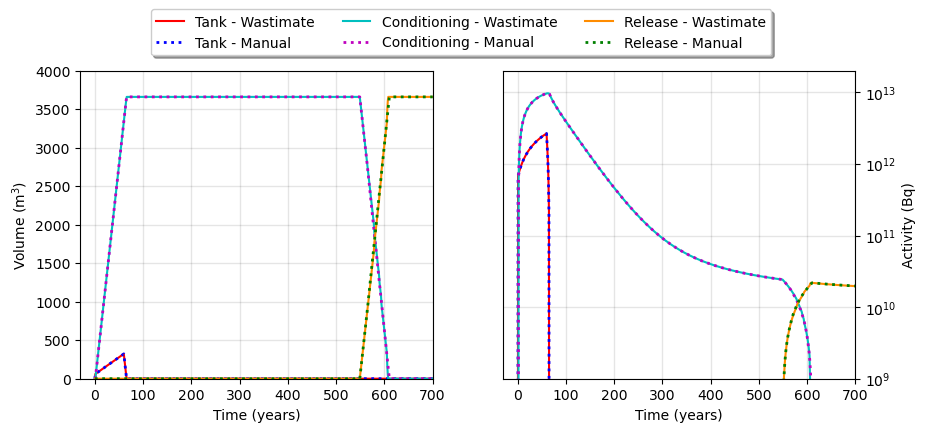

In [102]:
import matplotlib.pyplot as plt

Xx = np.array(list(range(0, 700+1)))
# Sample data
fig = plt.gcf()

# Create figure and axis objects
# Placing the plots in the plane 
plot1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1) 
plot2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1) 
#plot4 = plt.subplot2grid((3, 3), (1, 0), rowspan=2) 

# Plot y1 on the primary y-axis
line11, = plot1.plot(Xx, LiquidsMassList, color="red", linestyle="-", label='Tank - Wastimate', alpha=1, linewidth=1.5)
line12, = plot1.plot(Xx, liquids_mass, color="blue", linestyle=":", label='Tank - Manual', alpha=1, linewidth=2)
line13, = plot1.plot(Xx, ConditioningMassList, color="c", linestyle="-", label='Conditioning - Wastimate', linewidth=1.5, alpha=1)
line14, = plot1.plot(Xx, conditioning_mass, color="m", linestyle=":", label='Conditioning - Manual', alpha=1, linewidth=2)
line15, = plot1.plot(Xx, ReleaseMassList, color="darkorange", linestyle="-", label='Release - Wastimate', linewidth=1.5, alpha=1)
line16, = plot1.plot(Xx, release_mass, color="green", linestyle=":", label='Release - Manual', alpha=1, linewidth=2)

plot1.set_xlabel('Time (years)')
plot1.set_ylabel('Volume (m${}^{3}$)', color='k')
plot1.tick_params(axis='y', colors='k')
plot1.set_xlim([-30,700])
plot1.set_ylim([-0.5, 4000])
plot1.set_yscale("linear")

#plot2 = plot1.twinx()
#line21, = plot2.plot(X, LiquidsActivityList, color="green", linestyle="-", label='Activity - Wastimate', alpha=1)
#line22, = plot2.plot(X, liquids_activity, color="violet", linestyle="--", label='Activity - Manual', alpha=1, linewidth=2, dashes=(5, 5))
#plot2.set_ylabel('Y2', color='b')
#plot2.tick_params(axis='y', colors='b')

line21, = plot2.plot(Xx, LiquidsActivityList, color="red", linestyle="-", label='Tank - Wastimate', alpha=1, linewidth=1.5)
line22, = plot2.plot(Xx, liquids_activity, color="blue", linestyle=":", label='Tank - Manual', alpha=1, linewidth=2)
line23, = plot2.plot(Xx, ConditioningActivityList, color="c", linestyle="-", label='Conditioning - Wastimate', linewidth=1.5, alpha=1)
line24, = plot2.plot(Xx, conditioning_activity, color="m", linestyle=":", label='Conditioning - Manual', alpha=1, linewidth=2)
line25, = plot2.plot(Xx, ReleaseActivityList, color="darkorange", linestyle="-", label='Release - Wastimate', linewidth=1.5, alpha=1)
line26, = plot2.plot(Xx, release_activity, color="green", linestyle=":", label='Release - Manual', alpha=1, linewidth=2)

plot2.set_xlabel('Time (years)')
plot2.set_ylabel('Activity (Bq)', color='k')
plot2.tick_params(axis='y', colors='k')
plot2.set_xlim([-30,700])
plot2.set_ylim([1e9, 2e13])
plot2.set_yscale("symlog")

# Show legend
lines = [line11, line12, line21, line22]
labels = [line.get_label() for line in lines]
#plt.legend(lines, labels, loc='upper right')

# Show plot
plot1.grid(True, linestyle='-', linewidth=1, color='k', alpha=0.1)
plot2.grid(True, linestyle='-', linewidth=1, color='k', alpha=0.1)

plot2.yaxis.set_label_position("right")
plot2.yaxis.tick_right()

fig.set_size_inches(10, 4)

plt.legend(ncol=3, loc=(-1,1.05), shadow=True)

plt.savefig("LLW benchmark.png", dpi=200, bbox_inches='tight')

plt.show()
